In [1]:
using Flux, Plots
using ChainRulesCore
using Statistics
using Random
using MDToolbox
using CUDA
using BenchmarkTools
using EzXML
using CUDA.Adapt
ENV["COLUMNS"] = 130

130

In [2]:
@show collect(devices())
@show device!(1)
@show device()

collect(devices()) = CuDevice[CuDevice(0), CuDevice(1)]
device!(1) = CuDevice(1)
device() = CuDevice(1)


CuDevice(1): Quadro RTX 8000

In [3]:
pdb_filepath = "./alanine-dipeptide-nowater.pdb"
traj_dir = "./traj"
ff_dir = "./forcefield"
njobs = 7

target_traj_path = "./traj/traj8.dcd"
target_ff_filepath = "./forcefield/sim_8.xml"

const precision_type = Float64

Float64

In [4]:
#pythonのmdtrajのインデックスに+1してる
atom_pairs = [6 17]           #距離を計算する原子のペア
phi_indices = [5, 7, 9, 15]   #二面角ϕ
psi_indices = [7, 9, 15, 17]  #二面角ψ

#xmlファイルでのatom type
phi_atom_type = ["C", "N", "CT", "C"]
psi_atom_type = ["N", "CT", "C", "N"]

4-element Vector{String}:
 "N"
 "CT"
 "C"
 "N"

In [5]:
bandwidth = 0.005
num_points = 100

100

In [6]:
top = readpdb(pdb_filepath)
ta = mdload(target_traj_path, top=top)

for i in 1:length(top.atomid)
    println("atomid = $(top.atomid[i]), atomname = $(top.atomname[i])")
end
println()
#sanity check
@show ta[:,vec(atom_pairs)].atomname
@show ta[:, phi_indices].atomname
@show ta[:, psi_indices].atomname

atomid = 1, atomname = HH31
atomid = 2, atomname = CH3
atomid = 3, atomname = HH32
atomid = 4, atomname = HH33
atomid = 5, atomname = C
atomid = 6, atomname = O
atomid = 7, atomname = N
atomid = 8, atomname = H
atomid = 9, atomname = CA
atomid = 10, atomname = HA
atomid = 11, atomname = CB
atomid = 12, atomname = HB1
atomid = 13, atomname = HB2
atomid = 14, atomname = HB3
atomid = 15, atomname = C
atomid = 16, atomname = O
atomid = 17, atomname = N
atomid = 18, atomname = H
atomid = 19, atomname = CH3
atomid = 20, atomname = HH31
atomid = 21, atomname = HH32
atomid = 22, atomname = HH33

(ta[:, vec(atom_pairs)]).atomname = ["O", "N"]
(ta[:, phi_indices]).atomname = ["C", "N", "CA", "C"]
(ta[:, psi_indices]).atomname = ["N", "CA", "C", "N"]


4-element Vector{String}:
 "N"
 "CA"
 "C"
 "N"

In [7]:
phi = compute_dihedral(ta[:,phi_indices[1]], ta[:,phi_indices[2]], ta[:,phi_indices[3]], ta[:,phi_indices[4]]) * π / 180
psi = compute_dihedral(ta[:,psi_indices[1]], ta[:,psi_indices[2]], ta[:,psi_indices[3]], ta[:,psi_indices[4]]) * π / 180
dihedral_target = hcat(phi, psi)
distance_target = vec(compute_distance(ta, atom_pairs) ./ 10)

100000-element Vector{Float64}:
 0.4557272880032969
 0.3969620583928402
 0.40588421074375114
 0.45621472385467204
 0.3968975288671349
 0.41259354688401484
 0.4082375838915252
 0.404707033552233
 0.48863684289583753
 0.4152569827392904
 0.445251529434913
 0.3759139012473771
 0.37227408007451934
 ⋮
 0.40446336908483016
 0.5050478534369355
 0.3851853285293964
 0.4160895075690319
 0.3958587682847585
 0.4116100352112199
 0.4440289623113752
 0.398664211967022
 0.47490291274157925
 0.3893070333917464
 0.4591289142820673
 0.4492650034805128

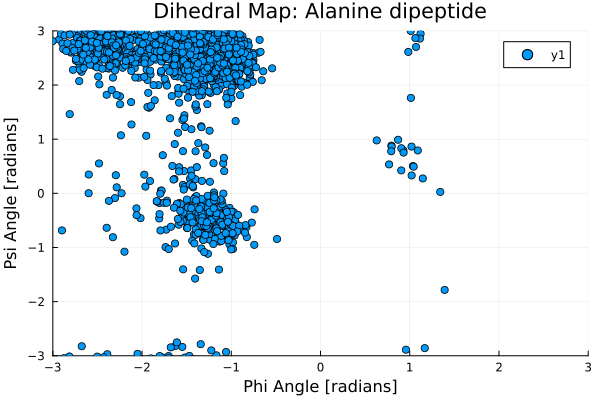

In [8]:
plot(dihedral_target[1:50:end, 1], dihedral_target[1:50:end, 2], st=scatter,
    xlabel="Phi Angle [radians]", ylabel="Psi Angle [radians]", title=("Dihedral Map: Alanine dipeptide"),
    xlim=(-3,3),ylim=(-3,3))

## distance distribution

In [9]:
"""
    function calc_histogram(data::AbstractVector;
                            rng=nothing,
                            bin_width=0.005, # nm
                            nbin=nothing,
                            density::Bool=false,
                            weight::AbstractArray=ones(length(data)))

Calculate a histogram of the input data `data`.

# Arguments
- `data::AbstractVector`: Input data vector.
- `rng::Tuple{Real, Real}`: Range of values to consider for the histogram. If not provided, the minimum and maximum values of `data` will be used.
- `bin_width::Real=0.005`: Width of each histogram bin.
- `nbin::Integer`: Number of bins for the histogram. If not provided, it will be automatically calculated based on `rng` and `bin_width`.
- `density::Bool=false`: If `true`, normalize the histogram to form a probability density.
- `weight::AbstractArray=[]`: Optional weights associated with each data point.

# Returns
- `hist::Array{Float64,1}`: Counts of data points in each bin.
- `bin_edge::Array{Float64,1}`: Edges of the bins.

# Examples
```julia-repl
julia> data = randn(1000)  # Generate random data
julia> hist, bin_edge = calc_histogram(data, rng=(-3, 3), bin_width=0.1, density=true)
```
"""
function calc_histogram(data::AbstractArray;
                        rng=nothing,
                        bin_width=0.005, # nm
                        nbin=nothing,
                        density::Bool=false,
                        weight::AbstractArray=ones(length(data)))
    
    # If range is not specified, use the range of the data
    if rng == nothing
        rng = (minimum(data), maximum(data))
    end
    # If data falls outside the specified range, ignore it
    data = filter(x -> rng[1] <= x && x <= rng[2], data)
    
    # If nbin is not specified, calculate it based on the bin width
    if nbin == nothing
        nbin = ceil(Int, (rng[2] - rng[1]) / bin_width)
    else
        # Recalculate bin width based on nbin
        bin_width = (rng[2] - rng[1]) / nbin
    end
    
    # Initialize histogram bins
    hist = zeros(Float64, nbin)
    
    # Calculate bin edges
    bin_edge = range(rng[1], rng[2], nbin+1) |> Vector
    
    # Calculate bin centers
    bin_center = (bin_edge[1:end-1] + bin_edge[2:end]) / 2
    
    # Fill histogram bins
    for (val, w) in zip(data, weight)
        bin_index = argmin(abs.(bin_center .- val))
        hist[bin_index] += w
    end
    
    # Normalize by total weight if density is true
    if density
        total_weight = sum(weight)
        hist ./= total_weight
    end
    
    return hist, bin_edge
end

calc_histogram

In [10]:
#?calc_histogram

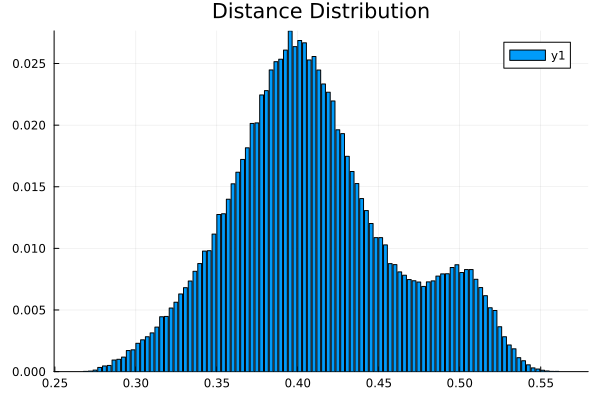

In [11]:
hist, bin_edge = calc_histogram(distance_target[1:end], density=true, nbin=num_points)
bin_center = (bin_edge[1:end-1] + bin_edge[2:end]) / 2
plot(bin_center, hist, st=bar, title="Distance Distribution")

In [12]:
function kde_estimate(data::AbstractArray; 
                    weight::AbstractArray = ones(length(data)), 
                    bandwidth=0.0, 
                    num_points::Int=1000, 
                    x_grid::AbstractVector=[])
    # If bandwidth is not specified, estimate it using Silverman's rule
    if bandwidth == 0.0
        n = length(data)
        s = std(data)
        IQR = quantile(data, 0.75) - quantile(data, 0.25)
        @show bandwidth = 0.9 * min(s, IQR / 1.34) / n^(1/5)
    end
    
    # Compute kernel density estimate
    if isempty(x_grid)
        x_grid = range(minimum(data), maximum(data), length=num_points) |> Vector
    end
    
    density_estimate = zeros(num_points)
    for i in 1:num_points
        x = x_grid[i]
        kernel_sum = 0.0
        for (val, w) in zip(data, weight)
            kernel_sum += w * exp(-((x - val) / bandwidth)^2 / 2) / sqrt(2 * π)
        end
        density_estimate[i] = kernel_sum / sum(weight) / bandwidth
    end
    
    return x_grid, density_estimate
end

kde_estimate (generic function with 1 method)

bandwidth = (0.9 * min(s, IQR / 1.34)) / n ^ (1 / 5) = 0.004325270001853674
  2.294688 seconds (120.08 M allocations: 1.795 GiB, 7.75% gc time)


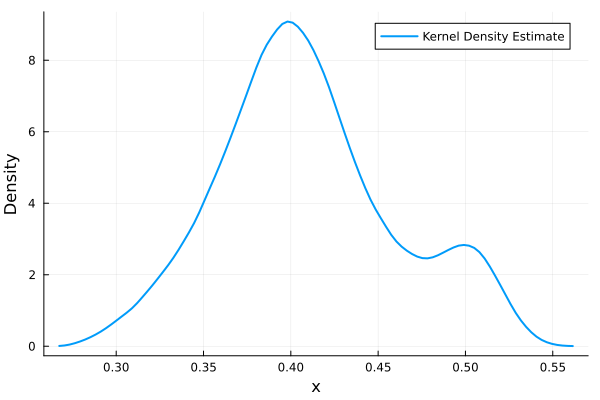

In [13]:
@time x_grid, density_estimate = kde_estimate(distance_target, num_points=num_points)
plot(x_grid, density_estimate, label="Kernel Density Estimate", xlabel="x", ylabel="Density", linewidth=2)

In [14]:
CUDA.allowscalar(false)

In [15]:
function kde_estimate_gpu(data::CuArray{T};
                            weight::CuArray{T}=adapt(CuArray, ones(T, length(data))), 
                            bandwidth::T=0.0, 
                            num_points::Int=1000, 
                            x_grid::CuArray{T}=adapt(CuArray, Float64[])) where {T}
    
    # If bandwidth is not specified, estimate it using Silverman's rule
    if bandwidth == 0.0
        n = length(data)
        s = std(data)
        IQR = quantile_range(data)
        bandwidth = T(0.9) * min(s, IQR / T(1.34)) / n^(T(1)/5)
    end
    
    # Compute kernel density estimate on the GPU
    if isempty(x_grid)
        x_min = minimum(data)
        x_max = maximum(data)
        x_grid = CuArray(range(T(x_min), T(x_max), length=num_points))
    end
  
    density_estimate = similar(x_grid)
    nthreads = num_points
    nblocks = ceil(Int, num_points / nthreads)
    @cuda threads=nthreads blocks=nblocks kde_estimate_kernel!(data, weight, bandwidth, density_estimate, x_grid)
    
    return x_grid, density_estimate
end

kde_estimate_gpu (generic function with 1 method)

In [16]:
function kde_estimate_gpu(data_k::AbstractArray{<:CuArray},
                            weight_k::AbstractArray{<:CuArray{T}}; 
                            bandwidth::T=0.0, 
                            num_points::Int=1000, 
                            x_grid::CuArray{T}=adapt(CuArray, Float64[])) where {T}

    K = length(data_k)
    N_k = Array{Int}(undef, K)
    for k in 1:K
        N_k[k] = length(data_k[k])
    end
    
    data = vcat(data_k...)
    weight = vcat(weight_k...)
    # If bandwidth is not specified, estimate it using Silverman's rule
    if bandwidth == 0.0
        n = length(data)
        s = std(data)
        IQR = quantile_range(data)
        bandwidth = T(0.9) * min(s, IQR / T(1.34)) / n^(T(1)/5)
    end
    
    # Compute kernel density estimate on the GPU
    if isempty(x_grid)
        x_min = minimum(data)
        x_max = maximum(data)
        x_grid = CuArray(range(T(x_min), T(x_max), length=num_points))
    end
  
    density_estimate = similar(x_grid)
    nthreads = num_points
    nblocks = ceil(Int, num_points / nthreads)
    @cuda threads=nthreads blocks=nblocks kde_estimate_kernel!(data, weight, bandwidth, density_estimate, x_grid)
    return density_estimate
end

# Define CUDA kernel function
function kde_estimate_kernel!(data::CuDeviceArray{T}, 
                          weight::CuDeviceArray{T}, 
                          bandwidth::T, 
                          density_estimate::CuDeviceArray{T},
                          x_grid::CuDeviceArray{T}) where {T}
    index = threadIdx().x
    stride = blockDim().x
    
    n = length(data)
    num_points = length(x_grid)
    
    for i = index:stride:num_points
        x = x_grid[i]
        kernel_sum = T(0)
        for j = 1:n
            kernel_sum += weight[j] * exp(-((x - data[j]) / bandwidth)^2 / T(2)) / sqrt(T(2 * π))
        end
        density_estimate[i] = kernel_sum / sum(weight) / bandwidth
    end
    return nothing
end

function ChainRulesCore.rrule(::typeof(kde_estimate_gpu), data_k::AbstractArray{<:CuArray},
                            weight_k::AbstractArray{<:CuArray{T}}; 
                            bandwidth::T=0.0, 
                            num_points::Int=1000, 
                            x_grid::CuArray{T}=adapt(CuArray, Float64[])) where {T}

    K = length(data_k)
    N_k = Array{Int}(undef, K)
    for k in 1:K
        N_k[k] = length(data_k[k])
    end
    
    data = vcat(data_k...)
    weight = vcat(weight_k...)
    # If bandwidth is not specified, estimate it using Silverman's rule
    if bandwidth == 0.0
        n = length(data)
        s = std(data)
        IQR = quantile_range(data)
        bandwidth = T(0.9) * min(s, IQR / T(1.34)) / n^(T(1)/5)
    end
    
    density_estimate = similar(x_grid)
    nthreads = num_points
    nblocks = ceil(Int, num_points / nthreads)
    @cuda threads=nthreads blocks=nblocks kde_estimate_kernel!(data, weight, bandwidth, density_estimate, x_grid)
    
    function kde_estimate_pullback(dU)
        K = length(data_k)
        N_k = Array{Int}(undef, K)
        for k in 1:K
            N_k[k] = length(data_k[k])
        end

        data = vcat(data_k...)
        weight = vcat(weight_k...)
        
        dweight_k = similar(weight_k)
        dweight = similar(weight)
        
        nthreads = num_points
        nblocks = ceil(Int, num_points / nthreads)
        @cuda threads=nthreads blocks=nblocks kde_estimate_pullback_aux!(data, weight, bandwidth, num_points, x_grid, dweight, dU)
        
        index_start = 1
        for k in 1:K
            index_end = index_start + N_k[k] - 1
            dweight_k[k] = dweight[index_start:index_end]
            index_start = index_end + 1
        end
        return NoTangent(), NoTangent(), dweight_k, NoTangent(), NoTangent(), NoTangent()
    end
    return density_estimate , kde_estimate_pullback
end

function kde_estimate_pullback_aux!(data::CuDeviceArray{T}, weight::CuDeviceArray{T},
                                    bandwidth::T,
                                    num_points::Int,
                                    x_grid::CuDeviceArray{T},
                                    dweight::CuDeviceArray{T},
                                    dU::CuDeviceArray{T}) where {T}

    index = threadIdx().x
    stride = blockDim().x
    n = length(data)
    for i in index:stride:num_points
        for j in 1:n
            dweight[j] += exp(-((x_grid[i] - data[j]) / bandwidth)^2 / 2.0 ) / (bandwidth * sqrt(2 * π)) * dU[i]
        end
    end
    return nothing
end

function quantile_range(data::CuArray{T}) where T
    n = length(data)
    sorted_data = sort(data)
    q1_index = Int(ceil(0.25 * n))
    q3_index = Int(floor(0.75 * n))
    CUDA.allowscalar() do
        q1 = sorted_data[q1_index]
        q3 = sorted_data[q3_index]
        return q3 - q1
    end
end

quantile_range (generic function with 1 method)

 13.378160 seconds (15.23 M allocations: 1.009 GiB, 2.96% gc time, 0.65% compilation time)


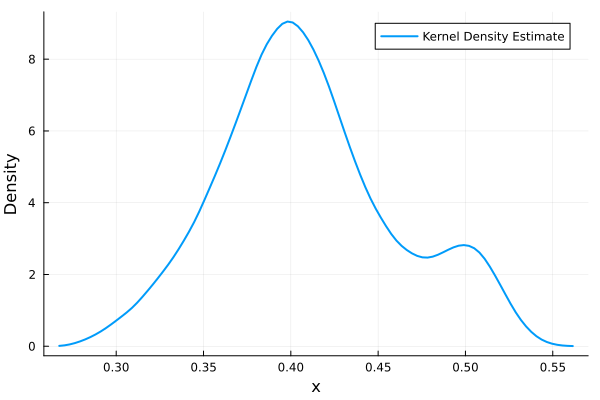

In [17]:
x_grid = adapt(CuArray, x_grid)
distance_target = adapt(CuArray, distance_target)
@time x_grid, density_estimate = kde_estimate_gpu(distance_target, x_grid=x_grid, bandwidth=bandwidth, num_points=num_points)
plot(x_grid |> cpu, density_estimate |> cpu, label="Kernel Density Estimate", xlabel="x", ylabel="Density", linewidth=2)

## input traj

In [18]:
dihedral_k = Array{Array{Float64}}(undef, njobs)
distance_k = Array{Array{Float64}}(undef, njobs)

for i in 1:njobs
    traj_filepath = joinpath(traj_dir, "traj$(i).dcd")
    ta = mdload(traj_filepath, top=top)

    phi = compute_dihedral(ta[:,phi_indices[1]], ta[:,phi_indices[2]], ta[:,phi_indices[3]], ta[:,phi_indices[4]]) * π / 180
    psi = compute_dihedral(ta[:,psi_indices[1]], ta[:,psi_indices[2]], ta[:,psi_indices[3]], ta[:,psi_indices[4]]) * π / 180
    dihedral_k[i] = hcat(phi, psi)
    
    distance = vec(compute_distance(ta, atom_pairs) ./ 10) #おそらくこれでnmに変換してる
    distance_k[i] = distance
end

## Reduce traj

In [19]:
isreduce = false
slice = 10
if isreduce == true
    distance_k = map(x -> x[1:slice:end], distance_k)
    dihedral_k = map(x -> x[1:slice:end, :], dihedral_k)
    distance_target = distance_target[1:slice:end]
    dihedral_target = dihedral_target[1:slice:end, :]
end

## input forcefield parameter

In [20]:
#二面角ϕ,ψに関連するパラメータはn,θ_zero,kの３つ
#最適化を目指すのはk

abstract type AbstractParam end

struct ParamCPU{T<:AbstractFloat}<:AbstractParam
    n::Vector{T}
    theta_zero::Vector{T}
    k::Vector{T}
end

struct Param{T<:AbstractFloat}<:AbstractParam
    n::CuArray{T}
    theta_zero::CuArray{T}
    k::CuArray{T}
end

function init_Param(ff_array::AbstractVector, gpu::Bool=false, T::DataType=Float64)
    n = T[]
    theta_zero = T[]
    k = T[]
    
    for line in ff_array
        #println(line)      
        if(occursin(r"type.*", line[1]))
            continue
        elseif(occursin(r"periodicity.*", line[1]))
            push!(n, parse(T, line[2]))
        elseif(occursin(r"phase.*", line[1]))
            push!(theta_zero, parse(T, line[2]))
        elseif(occursin(r"k.*", line[1]))
            push!(k, parse(T, line[2]))
        else
            println("ERROR")
        end
    end
    
    if(gpu) 
        n = adapt(CuArray, n)
        theta_zero = adapt(CuArray, theta_zero)
        k = adapt(CuArray, k)
        ff_param = Param(n, theta_zero, k)
        return ff_param
    end
    
    ff_param = ParamCPU(n, theta_zero, k)
    return ff_param
end

init_Param (generic function with 3 methods)

In [21]:
#力場ファイルから対象のパラメータを返す関数
function input_ff(ff_filepath; gpu=false::Bool)
    xml = readxml(ff_filepath)
    xmlroot = root(xml)
    
    children = elements(xmlroot)
    children_name = nodename.(children)
    torsion_index = children_name .== "PeriodicTorsionForce"
    torsion = children[torsion_index][1]
    
    phi_atom_type = ["C", "N", "CT", "C"]
    psi_atom_type = ["N", "CT", "C", "N"]
    
    ff_phi = []
    ff_psi = []
    for ff_params in eachelement(torsion)
        params_name = [nodename(i) for i in eachattribute(ff_params)]
        params_content = [nodecontent(i) for i in eachattribute(ff_params)]
        #println(params_content[1:4])
        if(params_content[1:4] == phi_atom_type)
            ff_phi = [(params_name[i], params_content[i]) for i in 1:length(params_name)]
        end
        if(params_content[1:4] == psi_atom_type)
            ff_psi = [(params_name[i], params_content[i]) for i in 1:length(params_name)]
        end
    end

    return init_Param(ff_phi, gpu), init_Param(ff_psi, gpu)
end

input_ff (generic function with 1 method)

In [22]:
ff_phi_k = Array{ParamCPU}(undef, njobs)
ff_psi_k = Array{ParamCPU}(undef, njobs)

for i in 1:njobs
    ff_filepath = joinpath(ff_dir, "sim_$(i).xml")
    ff_phi_k[i], ff_psi_k[i] = input_ff(ff_filepath)
end

#input target ff
ff_phi_target, ff_psi_target = input_ff(target_ff_filepath, gpu=true)

(Param{Float64}([1.0, 2.0, 3.0, 4.0, 2.0], [0.0, 0.0, 0.0, 0.0, 1.5707963267948966], [-0.14163188994724013, 1.467941446152554, 2.257861668812834, 0.32324481895832313, 1.5995961659045077]), Param{Float64}([1.0, 1.0, 2.0, 3.0, 4.0, 5.0, 1.0, 2.0, 3.0, 4.0, 5.0], [2.8080339837817268, 3.141592653589793, 3.141592653589793, 3.141592653589793, 3.141592653589793, 3.141592653589793, 1.5707963267948966, 1.5707963267948966, 1.5707963267948966, 1.5707963267948966, 1.5707963267948966], [2.6351371502810945, -0.8166651298560587, 5.976334813143396, 2.0119128492685574, -0.07485608032517561, -0.015644074546155885, -1.0431139293703353, 0.2995220759368923, 0.2297132337140822, 0.10157013468325342, -0.04504330406243621]))

In [23]:
#二面角のポテンシャルの計算
@inline function compute_dihedral_energy(theta::AbstractFloat, n::AbstractFloat, 
        theta_zero::AbstractFloat, k::AbstractFloat)
    return k * (1 + cos(n * theta - theta_zero))
end

function sum_compute_dihedral_energy(theta::AbstractFloat, ff_param::AbstractParam)
    return sum(compute_dihedral_energy.(theta, ff_param.n, ff_param.theta_zero, ff_param.k))
end

sum_compute_dihedral_energy (generic function with 1 method)

In [24]:
#compute u_kl
K = njobs
N_k = Array{Int}(undef, K)
for k in 1:K
    N_k[k] = length(distance_k[k])
end
KBT = KB_kcalpermol * 300
beta = Float64(1.0/(KBT))

u_kl = Array{Array{Float64}}(undef, (K, K))
for k in 1:K
    for l in 1:K
        u_kl[k, l] = map(i -> beta * sum_compute_dihedral_energy(dihedral_k[k][i, 1], ff_phi_k[l]) 
            + beta * sum_compute_dihedral_energy(dihedral_k[k][i, 2], ff_psi_k[l]), 1:N_k[k])
    end
end

In [25]:
f_k = Float64.(MDToolbox.mbar(u_kl))

iteration = 1  delta = 1.484984e+00  tol = 1.000000e-08
free energies =  0.000000 0.218658 0.285121 0.192046 -0.061469 0.294720 -0.224850

iteration = 2  delta = 2.643537e-02  tol = 1.000000e-08
free energies =  0.000000 0.223437 0.288206 0.186740 -0.061557 0.298316 -0.228850

iteration = 3  delta = 1.153944e-03  tol = 1.000000e-08
free energies =  0.000000 0.223610 0.288307 0.186508 -0.061552 0.298436 -0.228994

iteration = 4  delta = 4.449107e-05  tol = 1.000000e-08
free energies =  0.000000 0.223616 0.288311 0.186499 -0.061552 0.298441 -0.228999

iteration = 5  delta = 1.703697e-06  tol = 1.000000e-08
free energies =  0.000000 0.223617 0.288311 0.186499 -0.061552 0.298441 -0.229000

iteration = 6  delta = 6.521289e-08  tol = 1.000000e-08
free energies =  0.000000 0.223617 0.288311 0.186499 -0.061552 0.298441 -0.229000

iteration = 7  delta = 2.496113e-09  tol = 1.000000e-08
free energies =  0.000000 0.223617 0.288311 0.186499 -0.061552 0.298441 -0.229000

iteration = 8  delta = 9.55

7-element Vector{Float64}:
  0.0
  0.22361659068053039
  0.2883107637696799
  0.18649853192986762
 -0.06155208112477491
  0.2984406890063645
 -0.22899952645057706

## send from the CPU to the GPU

In [26]:
dihedral_k = adapt(Vector{CuArray}, dihedral_k)
distance_k = adapt(Vector{CuArray}, distance_k)
dihedral_target = adapt(CuArray, dihedral_target)
distance_target = adapt(CuArray, distance_target)

u_kl = adapt(Matrix{CuArray}, u_kl)

function send_gpu_param(ff_param::AbstractParam)
    if(typeof(ff_param) == Param)
        return ff_param
    end
    ff_param_gpu = Param(adapt(CuArray, ff_param.n), adapt(CuArray, ff_param.theta_zero), adapt(CuArray, ff_param.k))
    return ff_param_gpu
end

ff_phi_k = map(send_gpu_param, ff_phi_k)
ff_psi_k = map(send_gpu_param, ff_psi_k)

ff_phi_target = send_gpu_param(ff_phi_target)
ff_psi_target = send_gpu_param(ff_psi_target)

Param{Float64}([1.0, 1.0, 2.0, 3.0, 4.0, 5.0, 1.0, 2.0, 3.0, 4.0, 5.0], [2.8080339837817268, 3.141592653589793, 3.141592653589793, 3.141592653589793, 3.141592653589793, 3.141592653589793, 1.5707963267948966, 1.5707963267948966, 1.5707963267948966, 1.5707963267948966, 1.5707963267948966], [2.6351371502810945, -0.8166651298560587, 5.976334813143396, 2.0119128492685574, -0.07485608032517561, -0.015644074546155885, -1.0431139293703353, 0.2995220759368923, 0.2297132337140822, 0.10157013468325342, -0.04504330406243621])

## GPU kernel

In [27]:
#u_kを計算するための関数
function compute_u_kernel!(beta::T, dihedral::CuDeviceArray{T}, 
        n_phi::CuDeviceArray{T}, theta_zero_phi::CuDeviceArray{T}, k_phi::CuDeviceArray{T}, 
        n_psi::CuDeviceArray{T}, theta_zero_psi::CuDeviceArray{T}, k_psi::CuDeviceArray{T}, u::CuDeviceArray{T}) where {T}
    
    N = size(dihedral, 1)
    index = (blockIdx().x - 1) * blockDim().x + threadIdx().x
    stride = gridDim().x * blockDim().x

    phi_param_num = length(k_phi)
    psi_param_num = length(k_psi)

    for i in index:stride:N
        for j in 1:phi_param_num
            u[i] += beta * compute_dihedral_energy(dihedral[i, 1], n_phi[j], theta_zero_phi[j], k_phi[j])
        end
        for j in 1:psi_param_num
            u[i] += beta * compute_dihedral_energy(dihedral[i, 2], n_psi[j], theta_zero_psi[j], k_psi[j])
        end
    end

    return nothing
end

function compute_u_k(beta::T, dihedral_k::Vector{<:CuArray},
        n_phi::CuArray{T}, theta_zero_phi::CuArray{T}, k_phi::CuArray{T}, 
        n_psi::CuArray{T}, theta_zero_psi::CuArray{T}, k_psi::CuArray{T}) where {T}
    K = length(dihedral_k)
    N_k = Array{Int}(undef, K)
    for k in 1:K
        N_k[k] = size(dihedral_k[k], 1)
    end

    u_k = Vector{CuArray{T}}(undef, K)
    
    for k in 1:K
        nthreads = 256
        nblocks = ceil(Int, N_k[k] / nthreads)
        
        u_k[k] = adapt(CuArray, zeros(N_k[k]))
        @cuda threads=nthreads blocks=nblocks compute_u_kernel!(beta, dihedral_k[k], n_phi, theta_zero_phi, 
            k_phi, n_psi, theta_zero_psi, k_psi, u_k[k])
    end
    return u_k
end

function ChainRulesCore.rrule(::typeof(compute_u_k), beta::T, dihedral_k::Vector{<:CuArray}, 
        n_phi::CuArray{T}, theta_zero_phi::CuArray{T}, k_phi::CuArray{T}, 
        n_psi::CuArray{T}, theta_zero_psi::CuArray{T}, k_psi::CuArray{T}) where {T}
    
    K = size(dihedral_k, 1)
    N_k = Array{Int}(undef, K)
    for k in 1:K
        N_k[k] = size(dihedral_k[k], 1)
    end

    u_k = Vector{CuArray{T}}(undef, K)
    
    for k in 1:K
        nthreads = 256
        nblocks = ceil(Int, N_k[k] / nthreads)

        u_k[k] = adapt(CuArray, zeros(N_k[k]))
        @cuda threads=nthreads blocks=nblocks compute_u_kernel!(beta, dihedral_k[k], n_phi, theta_zero_phi, 
            k_phi, n_psi, theta_zero_psi, k_psi, u_k[k])
    end
    function compute_u_k_pullback(dU)
        dk_phi = similar(k_phi)
        dk_phi .= zero(Float64)
        dk_psi = similar(k_psi)
        dk_psi .= zero(Float64)
        
        for k = 1:K
            nthreads = 256
            nblocks = ceil(Int, N_k[k] / nthreads)
            @cuda threads=nthreads blocks=nblocks compute_u_pullback_aux!(dihedral_k[k], n_phi, theta_zero_phi, 
                n_psi, theta_zero_psi, dk_phi, dk_psi, dU[k])
        end
        return NoTangent(), NoTangent(), NoTangent(),
            NoTangent(), NoTangent(), dk_phi, NoTangent(), NoTangent(), dk_psi
    end
    return u_k, compute_u_k_pullback
end

function compute_u_pullback_aux!(dihedral::CuDeviceArray{U}, n_phi::CuDeviceArray{T}, theta_zero_phi::CuDeviceArray{T},
        n_psi::CuDeviceArray{T}, theta_zero_psi::CuDeviceArray{T}, 
        dk_phi::CuDeviceArray{T}, dk_psi::CuDeviceArray{T}, dU::CuDeviceArray{T}) where {T, U}
    
    N = size(dihedral, 1)

    phi_param_num = length(n_phi)
    psi_param_num = length(n_psi)

    index = (blockIdx().x - 1) * blockDim().x + threadIdx().x
    stride = gridDim().x * blockDim().x
    
    for i in index:stride:N
        for j in 1:phi_param_num
            dk_phi[j] += (1.0 + cos(n_phi[j] * dihedral[i, 1] - theta_zero_phi[j])) * dU[i]
        end
        for j in 1:psi_param_num
            dk_psi[j] += (1.0 + cos(n_psi[j] * dihedral[i, 2] - theta_zero_psi[j])) * dU[i]
        end
    end
    return nothing
end

compute_u_pullback_aux! (generic function with 1 method)

In [28]:
#w_kを計算する関数
function mbar_weight_gpu(u_kl::AbstractArray{<:CuArray}, f_k::AbstractArray{T}, u_k::AbstractArray{<:CuArray{T}}=nothing) where {T}
    K, L = size(u_kl)

    # N_k: number of data in k-th umbrella window
    N_k = zeros(Int64, K)
    for k = 1:K
        N_k[k] = length(u_kl[k, 1])
    end
    N_max = maximum(N_k)
    
    # conversion from array of array (u_kl) to array (u_kln)
    u_kln = adapt(CuArray, zeros(T, K, K, N_max))
    for k = 1:K
        for l = 1:K
            u_kln[k, l, 1:N_k[k]] .= u_kl[k, l]
        end
    end
    
    u_kn = adapt(CuArray, zeros(T, K, N_max))
    for k = 1:K
        if u_k === nothing
            u_kn[1, 1:N_k[k]] .= adapt(CuArray, zero(Float64))
        else
            u_kn[k, 1:N_k[k]] .= u_k[k]
        end
    end
    
    log_w_kn = adapt(CuArray, zeros(T, K, N_max))
    for k = 1:K
        log_w_kn[k, 1:N_k[k]] .= 1.0
    end
    idx = log_w_kn .> 0.5
    
    log_w_kn = mbar_log_wi_jn_gpu(N_k, f_k, u_kln, u_kn, K, N_max)
    log_w_n  = log_w_kn[idx]

    s = MDToolbox.logsumexp_1d(log_w_n)
    w_k = Vector{CuArray{Float64}}(undef, K)
    for k = 1:K
        w_k[k] = exp.((log_w_kn[k, 1:N_k[k]] .- s))
    end

    return w_k
end

function ChainRulesCore.rrule(::typeof(mbar_weight_gpu), 
        u_kl::AbstractArray{<:CuArray}, f_k::AbstractArray{T}, u_k::AbstractArray{<:CuArray{T}}) where {T}
    w_k = mbar_weight_gpu(u_kl, f_k, u_k)
    K = size(u_kl, 1)
    du_k = deepcopy(w_k)
    N_k = zeros(Int64, K)
    for k = 1:K
        N_k[k] = length(u_kl[k, 1])
    end
    function mbar_weight_gpu_pullback(dw_k)
        for k = 1:K
            nthreads = 256
            nblocks = ceil(Int, N_k[k] / nthreads)
            @cuda threads=nthreads blocks=nblocks mbar_weight_pullback_aux!(w_k[k], dw_k[k], du_k[k])
        end
        return NoTangent(), ZeroTangent(), NoTangent(), du_k
    end
    return w_k, mbar_weight_gpu_pullback
end

function mbar_weight_pullback_aux!(w::CuDeviceArray{T}, dw::CuDeviceArray{T}, du::CuDeviceArray{T}) where {T}
    index = (blockIdx().x - 1) * blockDim().x + threadIdx().x
    stride = gridDim().x * blockDim().x

    N = length(w)
    for i = index:stride:N
        du[i] = dw[i] * (-w[i])
    end

    return nothing
end

mbar_weight_pullback_aux! (generic function with 1 method)

In [29]:
function mbar_log_wi_jn_gpu(N_k::AbstractArray{U}, f_k::AbstractArray{T}, 
        u_kln::CuArray{T}, u_kn::CuArray{T}, K::Int64, N_max::Int64) where {T, U}
    log_wi_jn = adapt(CuArray, zeros(T, (K, N_max)))
    for k = 1:K
        tmp = adapt(CuArray, repeat(log.(N_k), 1, N_k[k]) .+ repeat(f_k, 1, N_k[k]))
        x = tmp .- (u_kln[k, :, 1:N_k[k]] .- repeat(u_kn[k:k, 1:N_k[k]], K, 1))
        log_wi_jn[k:k, 1:N_k[k]] .= - MDToolbox.logsumexp_over_row(x)
    end
    return log_wi_jn
end

mbar_log_wi_jn_gpu (generic function with 1 method)

In [30]:
#=
CUDA.allowscalar(false)
u_k = compute_u_k(beta, dihedral_k, 
    ff_phi_target.n, ff_phi_target.theta_zero, ff_phi_target.k,
    ff_psi_target.n, ff_psi_target.theta_zero, ff_psi_target.k)

w_k = mbar_weight_gpu(u_kl, f_k, u_k)
=#

## train

In [31]:
#重み付けした熱力学量の分布を計算する関数
#kde_estimate_gpu(distance_target_gpu, weight=w_k, x_grid=x_grid_gpu)

function compute_distribution_property(A_k::AbstractArray{<:CuArray}, dihedral_k::AbstractArray{<:CuArray}, 
        f_k::AbstractArray{T}, u_kl::AbstractArray{<:CuArray}, 
        beta::T, n_phi::CuArray{T}, theta_zero_phi::CuArray{T}, k_phi::CuArray{T}, 
        n_psi::CuArray{T}, theta_zero_psi::CuArray{T}, k_psi::CuArray{T}, x_grid::CuArray{T}) where {T}
    
    K = size(A_k, 1)
    u_k = Vector{CuArray{T}}(undef, K)
    u_k = compute_u_k(beta, dihedral_k, n_phi, theta_zero_phi,
        k_phi, n_psi, theta_zero_psi, k_psi)

    w_k = Array{CuArray{T}}(undef, K)
    w_k = mbar_weight_gpu(u_kl, f_k, u_k)

    density_estimate = kde_estimate_gpu(A_k, w_k, x_grid=x_grid, bandwidth=bandwidth, num_points=num_points)
    return density_estimate
end

compute_distribution_property (generic function with 1 method)

In [32]:
#n_effを計算する関数 (Σwₖ)² / Σ(wₖ²)

function compute_n_eff(w_k::AbstractVector{T}) where {T}
    K = size(w_k, 1)
    N = size(w_k[1], 1)

    n_eff = sum(map(i -> sum(w_k[i]), 1:K)) ^ 2 / sum(map(i -> sum(w_k[i] .^ 2), 1:K))
    return n_eff
end

function compute_n_eff(dihedral_k::AbstractArray{<:CuArray}, f_k::AbstractArray{T},
        u_kl::AbstractArray{<:CuArray}, beta::T,
        n_phi::CuArray{T}, theta_zero_phi::CuArray{T}, k_phi::CuArray{T},
        n_psi::CuArray{T}, theta_zero_psi::CuArray{T}, k_psi::CuArray{T}) where {T}
    
    K = size(dihedral_k, 1)
    u_k = Vector{CuArray{T}}(undef, K)
    u_k = compute_u_k(beta, dihedral_k, n_phi, theta_zero_phi,
        k_phi, n_psi, theta_zero_psi, k_psi)

    w_k = mbar_weight_gpu(u_kl, f_k, u_k)
    n_eff = compute_n_eff(w_k)
    return n_eff
end

compute_n_eff (generic function with 2 methods)

In [33]:
X_train = distance_k #距離の軌跡
_, y_train = kde_estimate_gpu(distance_target, x_grid=x_grid) #ターゲットの距離の分布

struct Energy{T<:AbstractArray}
    P::T #P[1] = k_phi, P[2] = k_psi
end

Flux.@functor Energy (P,)

(m::Energy)(X::AbstractArray{<:CuArray}) =compute_distribution_property(X, dihedral_k, f_k, 
        u_kl, beta, ff_phi_target.n, ff_phi_target.theta_zero, m.P[1], 
        ff_psi_target.n, ff_psi_target.theta_zero, m.P[2], x_grid)

#KL_divergenceのコードはバグがある
#=
function kl_divergence(p::CuArray{T}, q::CuArray{T}) where T
    kl_div = -sum(p .* log.(q ./ p))
    return kl_div
end

function ChainRulesCore.rrule(::typeof(kl_divergence), 
        p::CuArray{T}, q::CuArray{T}) where {T}
    kl_div = kl_divergence(p, q)
    function kl_divergence_pullback(dL)
        dp = similar(p)
        dq = similar(q)
        dp .= (log.(p ./ q) .+ 1) * dL
        dq .= (q ./ p .- 1) * dL

        return NoTangent(), dp, dq
    end
    return kl_div, kl_divergence_pullback
end
#loss(x, y) = kl_divergence(x, y)
=#

loss(x::AbstractArray{T}, y::AbstractArray{T}) where {T} = Flux.Losses.kldivergence(x, y)

loss (generic function with 1 method)

In [34]:
#sanity check
m_target = Energy([ff_phi_target.k, ff_psi_target.k])
loss(m_target(X_train), y_train)

0.4506101406545895

In [35]:
m = Energy([deepcopy(ff_phi_k[1].k), deepcopy(ff_psi_k[1].k)])
loss(m(X_train), y_train)

0.106118514152854

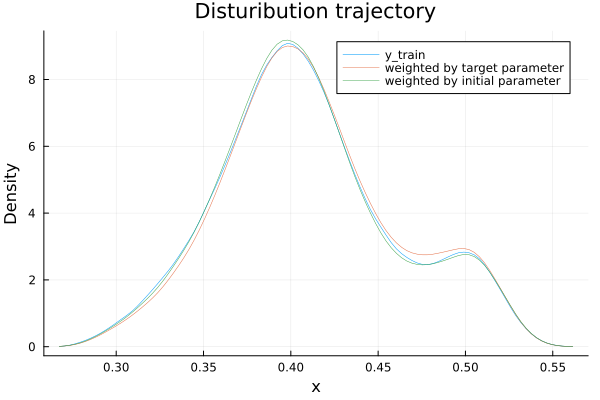

In [36]:
plot(x_grid |> cpu, y_train |> cpu, label="y_train", linewidth=0.5)
plot!(x_grid |> cpu, m_target(X_train) |> cpu, label="weighted by target parameter", linewidth=0.5)
plot!(x_grid |> cpu, m(X_train) |> cpu, label="weighted by initial parameter", linewidth=0.5)
plot!(title="Disturibution trajectory", xlabel="x", ylabel="Density")

In [37]:
function compute_average_property(x_grid::AbstractArray{T}, density_estimate::AbstractArray{T}) where {T}
    return sum(x_grid .* density_estimate / sum(density_estimate))
end

@show compute_average_property(x_grid, y_train)
@show compute_average_property(x_grid, m_target(X_train))
@show compute_average_property(x_grid, m(X_train))

compute_average_property(x_grid, y_train) = 0.40965227711073837
compute_average_property(x_grid, m_target(X_train)) = 0.41183085387803053
compute_average_property(x_grid, m(X_train)) = 0.4094883385641094


0.4094883385641094

In [38]:
#CUDA.@profile trace=false g = gradient(m -> loss(m(), y_train), m)[1]

In [39]:
function print_progress(epoch, loss, m, n_eff)
    println("Epoch: $epoch, loss: $loss")
    println("param: $(m.P[1]), n_eff = $n_eff")
end

print_progress (generic function with 1 method)

In [40]:
k_phi_estimated_array = []
k_psi_estimated_array = []
n_eff_array = []

Any[]

In [41]:
#=
CUDA.allowscalar(false)
g = gradient(m -> loss(m(X_train), y_train), m)[1]
=#

In [ ]:
CUDA.allowscalar(false)
loss_train = []
nepoch = 50
learning_rate = 1e-5
println("Initial loss: $(loss(m(X_train), y_train))")
println("Initial param: $(m.P[1])")
threshold = sum(N_k) / 2
t = Flux.Optimisers.setup(Adam(learning_rate), m) |> Flux.gpu

result, time = @timed for epoch in 1:nepoch

    g = gradient(m -> loss(m(X_train), y_train), m)[1]
    Flux.Optimisers.update!(t, m, g)
    
    L = loss(m(X_train), y_train)
    push!(loss_train, L)

    push!(k_phi_estimated_array, deepcopy(m.P[1]))
    push!(k_psi_estimated_array, deepcopy(m.P[2]))

    n_eff = compute_n_eff(dihedral_k, f_k, u_kl, beta, ff_phi_target.n, ff_phi_target.theta_zero,
        m.P[1], ff_psi_target.n, ff_psi_target.theta_zero, m.P[2])

    if (epoch % (nepoch / 10) == 0)
        print_progress(epoch, L, m, n_eff)
    end

    #終了判定
    if(n_eff < threshold)
        ###
    end
end

Initial loss: 0.106118514152854
Initial param: [-0.1396954369058983, 1.4020721749174487, 2.2722793075263983, 0.33249158784820976, 1.669819011164073]
Epoch: 5, loss: 0.10605807434785675
param: [-0.1396868090882697, 1.402067230513598, 2.2723026228582737, 0.3324843302982658, 1.6697758859850558], n_eff = 697957.1745318269
Epoch: 10, loss: 0.10595270634689768
param: [-0.13969210616285427, 1.4020467241010586, 2.272302472527382, 0.3324642294623859, 1.6697379088954525], n_eff = 697953.7485797697
Epoch: 15, loss: 0.10586849899846129
param: [-0.1397029174823337, 1.402026937472654, 2.272310150055923, 0.33243898916136033, 1.669711072325233], n_eff = 697951.6608049016
Epoch: 20, loss: 0.10579353422531312
param: [-0.13970953176548642, 1.4020000610056667, 2.2723227083675135, 0.33243646187808285, 1.6696857561051666], n_eff = 697948.4745451128
Epoch: 25, loss: 0.10566616714118027
param: [-0.13971127960439372, 1.4019697104774085, 2.272322639974091, 0.3324341080693524, 1.6696578748155582], n_eff = 697945

## result

In [ ]:
plot(loss_train, legend=nothing, framestyle=:box, linewidth=2, title="Loss")
ylabel!("Loss")
xlabel!("Epoch")
#savefig(joinpath(figure_dir, "Loss_50step.png"))

In [ ]:
phi_dif = map(i -> (k_phi_estimated_array[i] - ff_phi_target.k) .^ 2, 1:nepoch) |> cpu
psi_dif = map(i -> (k_psi_estimated_array[i] - ff_psi_target.k) .^ 2, 1:nepoch) |> cpu

#二乗誤差
phi_squared_error = map(x -> sum(x), phi_dif)
psi_squared_error = map(x -> sum(x), psi_dif)

phi_dif = [[phi_dif[j][i] for j in 1:nepoch] for i in 1:size(ff_phi_target.k, 1)]
psi_dif = [[psi_dif[j][i] for j in 1:nepoch] for i in 1:size(ff_psi_target.k, 1)]

plot(phi_squared_error, xlabel="Epoch", title="Psi Squared Error")

In [ ]:
plot(psi_squared_error, xlabel="Epoch", title="Psi Squared Error")

In [ ]:
#k_phiと正解の二乗誤差
plt = []
for i in 1:size(ff_phi_target.k, 1)
    tmp = plot()
    plot!(tmp, phi_dif[i], title="k$i")
    push!(plt, tmp)
end
tmp = plot()
plot!(tmp, loss_train, title="Loss")
push!(plt, tmp)

plot(plt...)

In [ ]:
#k_psiと正解の二乗誤差
plt = []
for i in 1:size(ff_psi_target.k, 1)
    tmp = plot()
    plot!(tmp, psi_dif[i], title="k$i")
    push!(plt, tmp)
end
tmp = plot()
plot!(tmp, loss_train, title="Loss")
push!(plt, tmp)

plot(plt...)